In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/AFCS

Mounted at /content/drive
/content/drive/MyDrive/AFCS


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error

In [3]:
calendar = pd.read_csv("calendar_afcs2023.csv")
sell_prices = pd.read_csv("sell_prices_afcs2023.csv")
sales_train = pd.read_csv("sales_train_validation_afcs2023.csv")
sales_test = pd.read_csv("sales_test_validation_afcs2022.csv") # only use for testing
sample_submission = pd.read_csv("sample_submission_afcs2023.csv")

In [4]:
sales_train

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_3_001_TX_3_validation,0,2,1,3,0,0,1,0,2,...,0,0,0,0,2,0,0,5,2,0
1,FOODS_3_002_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,FOODS_3_003_TX_3_validation,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0
3,FOODS_3_004_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
4,FOODS_3_005_TX_3_validation,0,1,1,0,0,1,2,0,0,...,0,4,2,1,1,0,1,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,FOODS_3_823_TX_3_validation,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,2,0,2
819,FOODS_3_824_TX_3_validation,0,1,0,1,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0
820,FOODS_3_825_TX_3_validation,0,0,0,2,1,1,0,0,1,...,1,1,1,3,1,0,0,4,2,0
821,FOODS_3_826_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,2,1,1,5,3,1,2,1,2


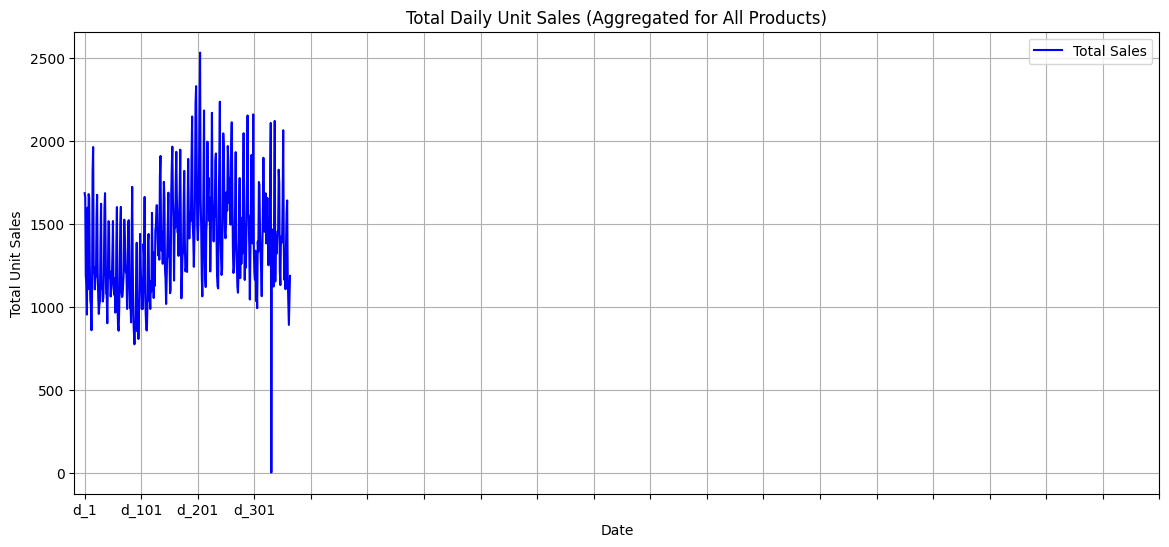

In [8]:
total_sales = sales_train.iloc[:, 1:].sum(axis=0)

plt.figure(figsize=(14, 6))
plt.plot(total_sales.index, total_sales.values, label='Total Sales', color='blue')
plt.title('Total Daily Unit Sales (Aggregated for All Products)')
plt.xlabel('Date')
plt.ylabel('Total Unit Sales')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 1913, 100))
plt.show()

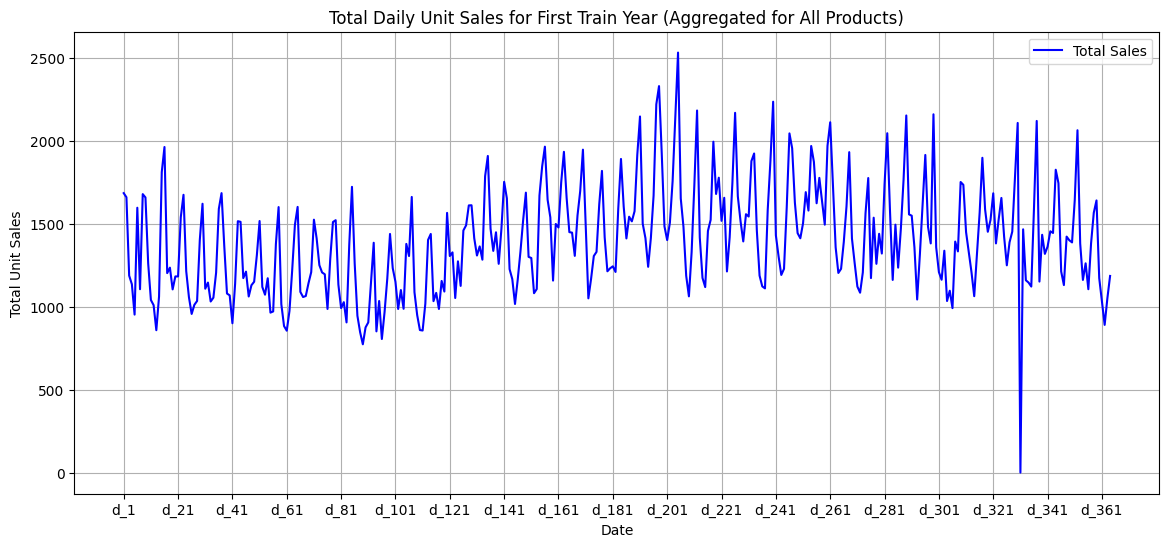

In [14]:
plt.figure(figsize=(14, 6))
plt.plot(total_sales[:364].index, total_sales[:364].values, label='Total Sales', color='blue')
plt.title('Total Daily Unit Sales for First Train Year (Aggregated for All Products)')
plt.xlabel('Date')
plt.ylabel('Total Unit Sales')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 364, 20))
plt.show()

In [22]:
# Merging the sales train file with the calendar file to better see patterns on actuals dates and be able to see
# sales on day of week and see events.

sales_train_long = pd.melt(sales_train, id_vars=['id'],
                           var_name='day', value_name='sales')
sales_train_long['day'] = pd.to_datetime('2011-01-29') + pd.to_timedelta(sales_train_long['day'].str[2:].astype(int) - 1, unit='D')
calendar['date'] = pd.to_datetime(calendar['date'])

merged_data = pd.merge(sales_train_long, calendar, left_on='day', right_on='date', how='left')

merged_data

,id,day,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX
0,FOODS_3_001_TX_3_validation,2011-01-29,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
1,FOODS_3_002_TX_3_validation,2011-01-29,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
2,FOODS_3_003_TX_3_validation,2011-01-29,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
3,FOODS_3_004_TX_3_validation,2011-01-29,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
4,FOODS_3_005_TX_3_validation,2011-01-29,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574394,FOODS_3_823_TX_3_validation,2016-04-24,2,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0
1574395,FOODS_3_824_TX_3_validation,2016-04-24,0,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0
1574396,FOODS_3_825_TX_3_validation,2016-04-24,0,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0
1574397,FOODS_3_826_TX_3_validation,2016-04-24,2,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0


from matplotlib import pyplot as plt
merged_data['sales'].plot(kind='hist', bins=20, title='sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
merged_data['wm_yr_wk'].plot(kind='hist', bins=20, title='wm_yr_wk')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
merged_data['wday'].plot(kind='hist', bins=20, title='wday')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
merged_data['month'].plot(kind='hist', bins=20, title='month')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
merged_data.groupby('weekday').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
merged_data.groupby('event_type_1').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
merged_data.groupby('event_name_2').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
merged_data.groupby('event_type_2').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
merged_data.plot(kind='scatter', x='sales', y='wm_yr_wk', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
merged_data.plot(kind='scatter', x='wm_yr_wk', y='wday', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
merged_data.plot(kind='scatter', x='wday', y='month', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
merged_data.plot(kind='scatter', x='month', y='year', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['day']
  ys = series['sales']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = merged_data.sort_values('day', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('weekday')):
  _plot_series(series, series_name, i)
  fig.legend(title='weekday', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('day')
_ = plt.ylabel('sales')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['day']
  ys = series['sales']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = merged_data.sort_values('day', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('event_type_1')):
  _plot_series(series, series_name, i)
  fig.legend(title='event_type_1', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('day')
_ = plt.ylabel('sales')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['day']
  ys = series['sales']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = merged_data.sort_values('day', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('event_name_2')):
  _plot_series(series, series_name, i)
  fig.legend(title='event_name_2', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('day')
_ = plt.ylabel('sales')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['day']
  ys = series['sales']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = merged_data.sort_values('day', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('event_type_2')):
  _plot_series(series, series_name, i)
  fig.legend(title='event_type_2', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('day')
_ = plt.ylabel('sales')

from matplotlib import pyplot as plt
merged_data['sales'].plot(kind='line', figsize=(8, 4), title='sales')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
merged_data['wm_yr_wk'].plot(kind='line', figsize=(8, 4), title='wm_yr_wk')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
merged_data['wday'].plot(kind='line', figsize=(8, 4), title='wday')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
merged_data['month'].plot(kind='line', figsize=(8, 4), title='month')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['event_type_1'].value_counts()
    for x_label, grp in merged_data.groupby('weekday')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('weekday')
_ = plt.ylabel('event_type_1')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['event_name_2'].value_counts()
    for x_label, grp in merged_data.groupby('event_type_1')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('event_type_1')
_ = plt.ylabel('event_name_2')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['event_type_2'].value_counts()
    for x_label, grp in merged_data.groupby('event_name_2')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('event_name_2')
_ = plt.ylabel('event_type_2')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(merged_data['weekday'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(merged_data, x='sales', y='weekday', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(merged_data['event_type_1'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(merged_data, x='sales', y='event_type_1', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(merged_data['event_name_2'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(merged_data, x='sales', y='event_name_2', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(merged_data['event_type_2'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(merged_data, x='sales', y='event_type_2', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

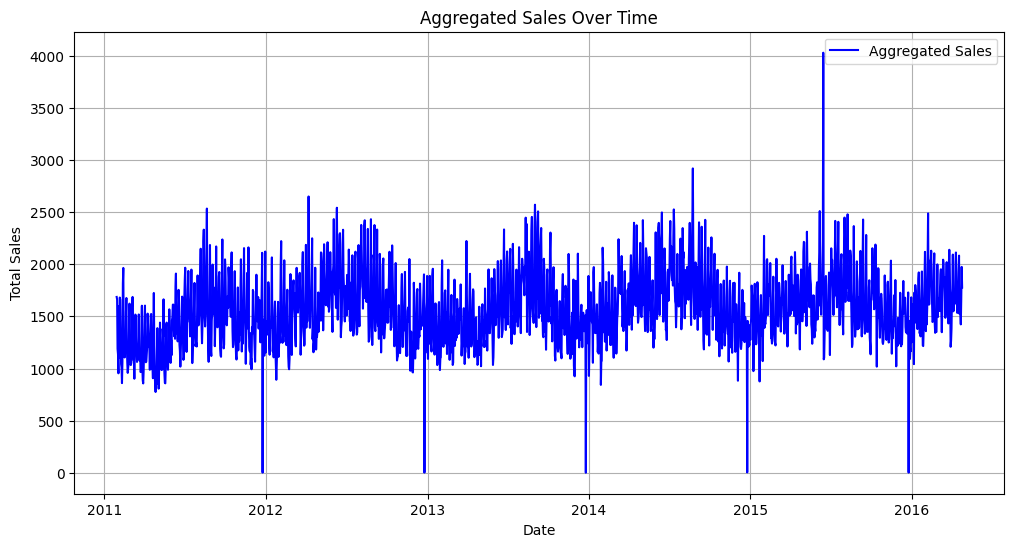

In [23]:
# now we can show sales with actual dates, day of week etc.

daily_sales = merged_data.groupby('day')['sales'].sum()


plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales.values, label='Aggregated Sales', color='blue')
plt.title('Aggregated Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.legend()
plt.show()

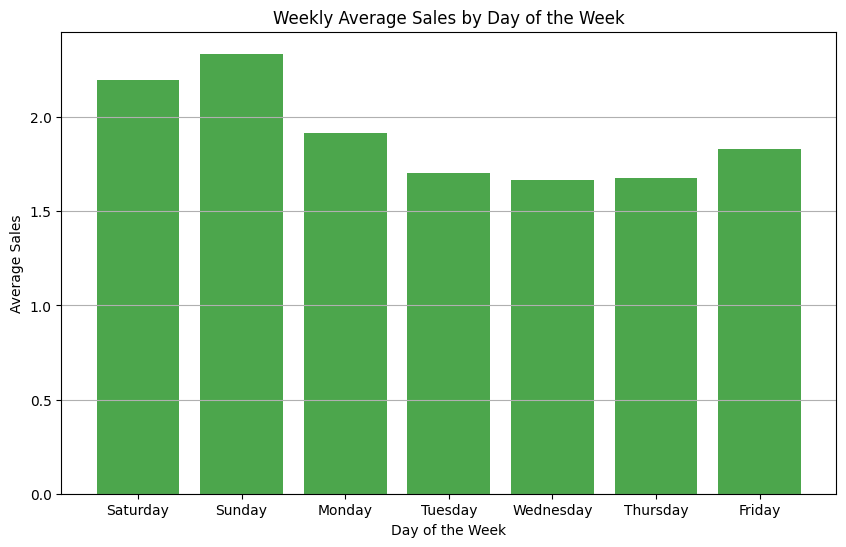

In [24]:
weekly_avg_sales = merged_data.groupby('weekday')['sales'].mean()

# Order days of the week for proper plotting
ordered_days = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekly_avg_sales = weekly_avg_sales.reindex(ordered_days)

plt.figure(figsize=(10, 6))
plt.bar(weekly_avg_sales.index, weekly_avg_sales.values, color='green', alpha=0.7)
plt.title('Weekly Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.grid(axis='y')
plt.show()

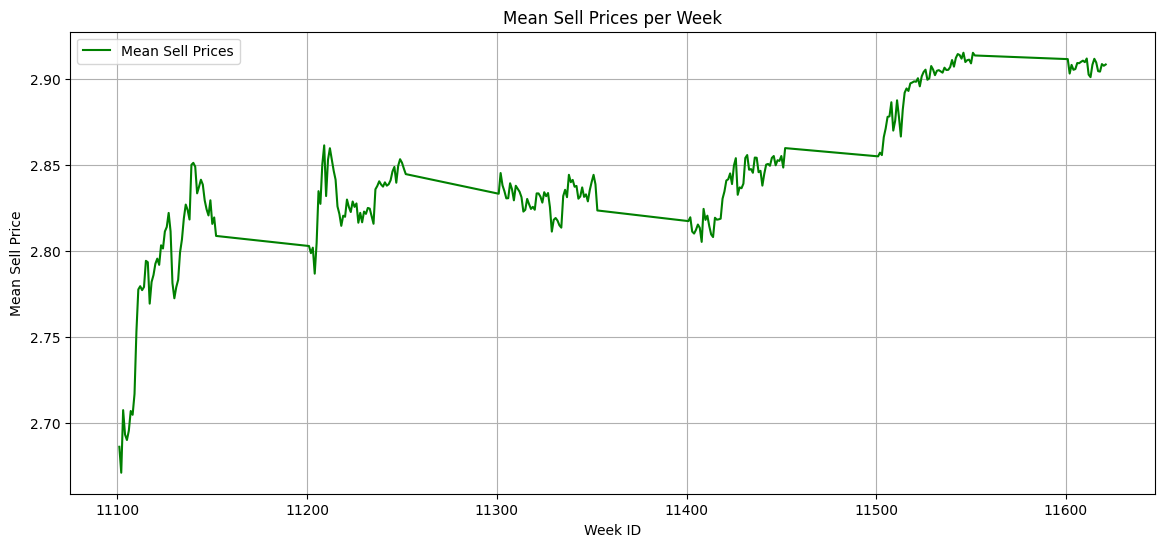

In [6]:
mean_prices = sell_prices.groupby('wm_yr_wk')['sell_price'].mean()

plt.figure(figsize=(14, 6))
plt.plot(mean_prices.index, mean_prices.values, label='Mean Sell Prices', color='green')
plt.title('Mean Sell Prices per Week')
plt.xlabel('Week ID')
plt.ylabel('Mean Sell Price')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Prediction using the Prophet model: https://facebook.github.io/prophet/
# From our findings above we can see clear yearly and weekly seasonality.

all_forecasts = []

# Iterate through each unique product in the dataset
for product_id in merged_data['id'].unique():
    # Filter data for the current product
    product_data = merged_data[merged_data['id'] == product_id]

    # Prepare the dataframe for Prophet
    prophet_df = product_data[['day', 'sales']].rename(columns={'day': 'ds', 'sales': 'y'})
    prophet_df['floor'] = 0

    # Instantiate Prophet model with yearly and weekly seasonality
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

    # Fit the model
    model.fit(prophet_df)

    # Create a dataframe for future dates (next 28 days)
    future = model.make_future_dataframe(periods=28)

    # Generate forecasts
    forecast = model.predict(future)

    # Round to nearest int
    forecast['yhat'] = forecast['yhat'].round()

    # Extract relevant information for the submission and reshape
    product_forecast = forecast[['ds', 'yhat']].tail(28).rename(columns={'ds': 'day', 'yhat': 'sales'})
    product_forecast['id'] = product_id

    # Pivot the dataframe to wide format
    product_forecast_wide = product_forecast.pivot(index='id', columns='day', values='sales').reset_index()
    product_forecast_wide.columns = ['id'] + [f'F{i}' for i in range(1, 29)]

    # Append the forecast to the list
    all_forecasts.append(product_forecast_wide)

# Concatenate all individual product forecasts into a single dataframe
all_forecasts_df = pd.concat(all_forecasts, ignore_index=True)

# Make submission file
all_forecasts_df.to_csv('submission.csv', index=False)

Streaminguitvoer ingekort tot de laatste 5000 regels.
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7448', 'data', 'file=/tmp/tmp1afpboyi/5z737xoi.json', 'init=/tmp/tmp1afpboyi/fuy3j929.json', 'output', 'file=/tmp/tmp1afpboyi/prophet_model2f0upogh/prophet_model-20231212115809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:58:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:58:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1afpboyi/3zekp29r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1afpboyi/mf2sps39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48638', 'data', 'file=/tmp/tmp1afpboyi/3zekp29r.json', 'init=/

In [31]:
# Merge forecasts and true values on the item_id column
merged_results = pd.merge(sales_test, all_forecasts_df, on='id', how='left')

# Extract true values and forecasted values
true_values = merged_results[['id'] + [f'd_{i}' for i in range(1914, 1942)]]
forecasted_values = merged_results[['id'] + [f'F{i}' for i in range(1, 29)]]

# Convert the DataFrames to numpy arrays
true_values_arr = true_values.drop('id', axis=1).to_numpy()
forecasted_values_arr = forecasted_values.drop('id', axis=1).to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_values_arr, forecasted_values_arr))

print(f'RMSE: {rmse}')

RMSE: 3.3133914271517413
